In [1]:
%%capture nop
import os 
IS_KAGGLE = not not os.environ.get('KAGGLE_KERNEL_RUN_TYPE','')
if IS_KAGGLE:
    !git clone https://github.com/Janluke0/PoS-Tagging/
    os.chdir('PoS-Tagging')
    !pip install positional-encodings bpemb
else:
    os.chdir('..')


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pytorch_lightning as pl
import torch
GPU = 1 if torch.cuda.is_available() else 0

In [3]:
from dataset.tokenizer import get_tokenizer
from dataset.twtita import mk_dataloaders, TWITADS

import model.attention as attention
from model import TokenOfSeqClassifier

TAGS = TWITADS._TAGS

In [4]:
available = ["BPE", "WordPiece","BERT_pretrained", "ELECTRA_pretrained", "ROBERTA_pretrained", "DBERT_pretrained"]

In [5]:
def mk4tknzr(name):
    tknzr = get_tokenizer('resampled_train',name)
    ntags, dl_train = mk_dataloaders(tknzr,['resampled_train'],batch_size=256)
    vocab = tknzr.vocab_size if hasattr(tknzr,'vocab_size')  else tknzr.get_vocab_size()
    _, dl_val, dl_test = mk_dataloaders(tknzr,['resampled_validation','test'], shuffle=False,batch_size=256)
    model =  attention.TokenizedSeq2Seq(d_input=vocab, d_model=128, d_output=ntags, dropout=0.5, in_seq_pad=0, nheads=2, N=3)
    pl_model = TokenOfSeqClassifier(model, 
                                    nclass=len(TAGS),
                                    pad_index=TAGS['[PAD]'],
                                    label_idx_to_ignore=[ TAGS['[EPAD]'],TAGS['[BOS]'], TAGS['[EOS]'], TAGS['[PAD]']])
    return pl_model, (dl_train,dl_val,dl_test)


def plot_curves(model):
    acc, loss = model.val_metrics['accuracy'],model.val_metrics['loss']
    print(acc[-1],max(acc))
    print(loss[-1],min(loss))
    plt.figure(figsize=(16,8))
    plt.subplot(121)
    plt.plot(acc)
    plt.subplot(122)
    plt.plot(loss)
    
early_stopping = lambda: pl.callbacks.EarlyStopping(monitor='val_acc',min_delta=1e-6,mode='max',patience=400)
checkpoints = lambda: pl.callbacks.ModelCheckpoint(monitor='val_acc',mode='max')

In [6]:
%%capture nop
model, (dl_train,dl_val,dl_test) = mk4tknzr('BPE')
trainer = pl.Trainer(log_every_n_steps=2,gpus=GPU, max_epochs=2000, callbacks=[early_stopping(), checkpoints()])
trainer.fit(model, dl_train, dl_val)

0.8741892576217651 0.8790759444236755
0.4344596564769745 0.2348124086856842


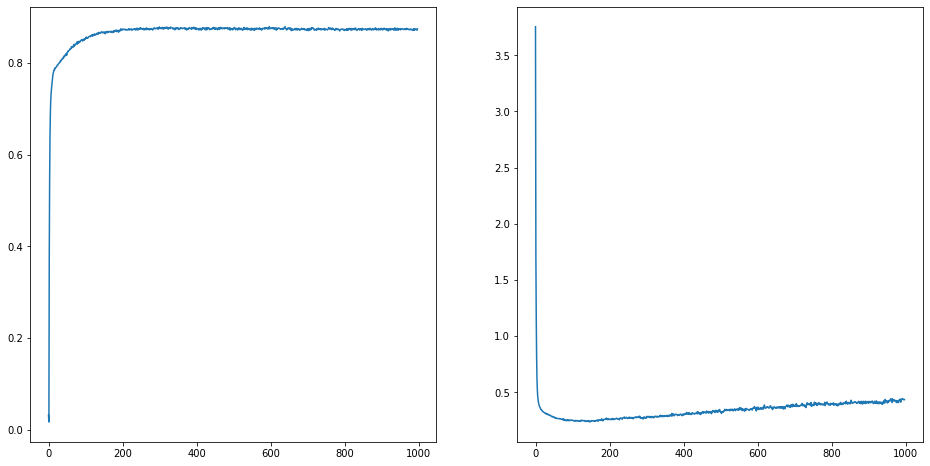

In [7]:
plot_curves(model)

In [8]:
%%capture nop
model, (dl_train,dl_val,dl_test) = mk4tknzr('WordPiece')
trainer = pl.Trainer(log_every_n_steps=2,gpus=GPU, max_epochs=2000, callbacks=[early_stopping(), checkpoints()])
trainer.fit(model, dl_train, dl_val)

0.8743334412574768 0.8804656863212585
0.5169678926467896 0.2583349049091339


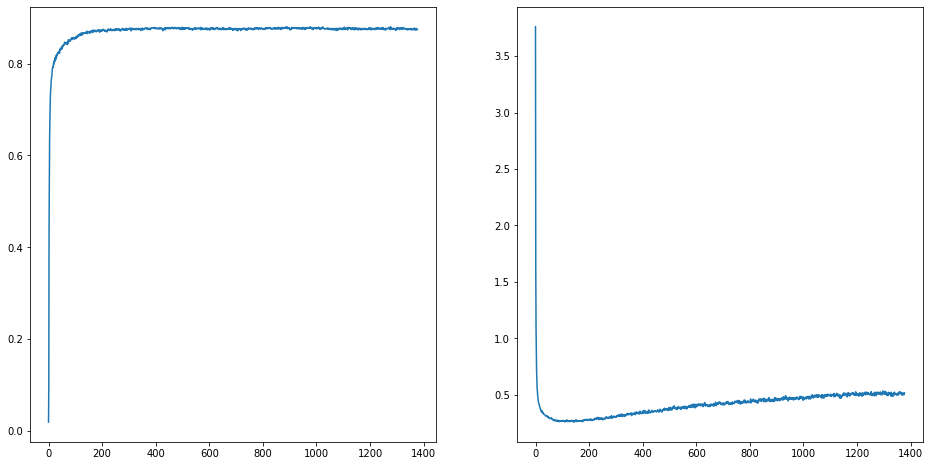

In [9]:
plot_curves(model)

In [10]:
%%capture nop
model, (dl_train,dl_val,dl_test) = mk4tknzr('BERT_pretrained')
trainer = pl.Trainer(log_every_n_steps=2,gpus=GPU, max_epochs=2000, callbacks=[early_stopping(), checkpoints()])
trainer.fit(model, dl_train, dl_val)

0.876288652420044 0.8861535787582397
0.9041807055473328 0.40259355306625366


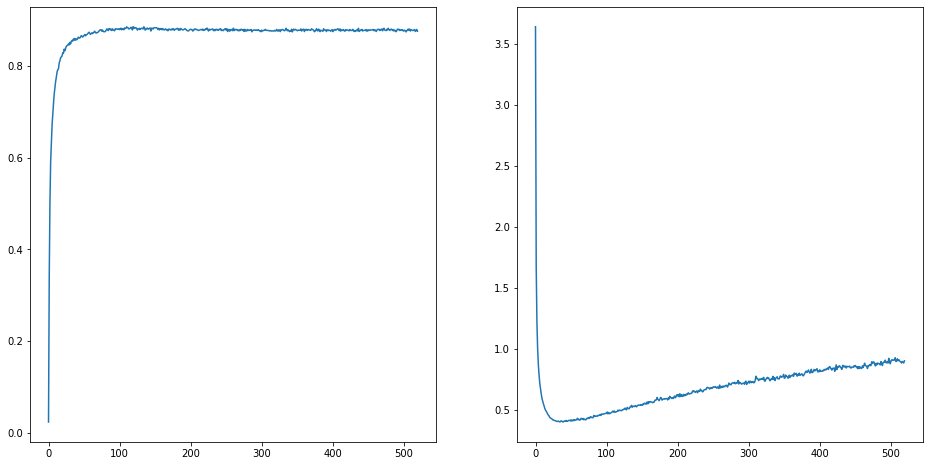

In [11]:
plot_curves(model)

In [12]:
%%capture nop
model, (dl_train,dl_val,dl_test) = mk4tknzr('DBERT_pretrained')
trainer = pl.Trainer(log_every_n_steps=2,gpus=GPU, max_epochs=120, callbacks=[early_stopping(), checkpoints()])
trainer.fit(model, dl_train, dl_val)

0.8670812845230103 0.8681474924087524
0.45579683780670166 0.40282341837882996


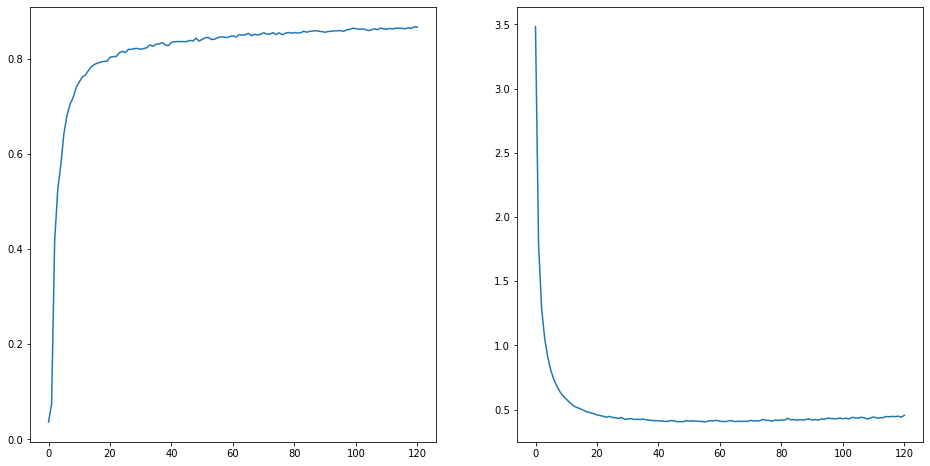

In [13]:
plot_curves(model)

In [14]:
%%capture nop
model, (dl_train,dl_val,dl_test) = mk4tknzr('ELECTRA_pretrained')
trainer = pl.Trainer(log_every_n_steps=2,gpus=GPU, max_epochs=2000, callbacks=[early_stopping(), checkpoints()])
trainer.fit(model, dl_train, dl_val)

0.8764104843139648 0.8828964829444885
0.9454792141914368 0.4069322645664215


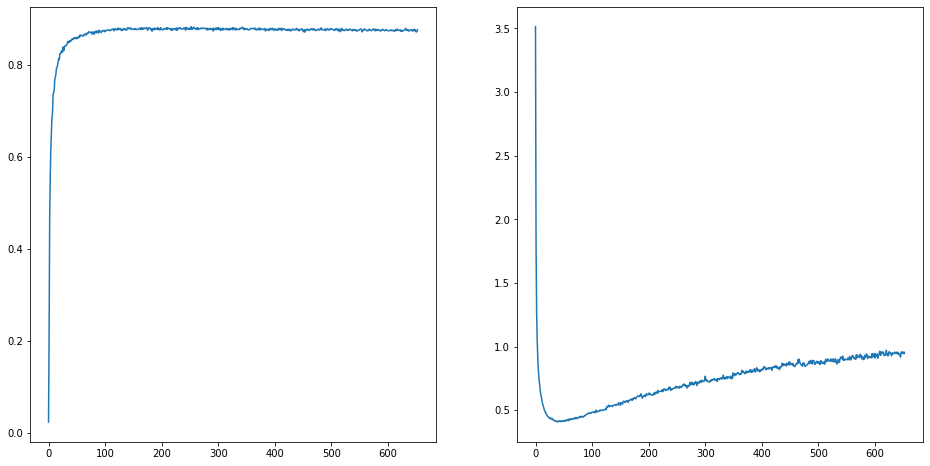

In [15]:
plot_curves(model)

In [16]:
%%capture nop
model, (dl_train,dl_val,dl_test) = mk4tknzr('ROBERTA_pretrained')
trainer = pl.Trainer(log_every_n_steps=2,gpus=GPU, max_epochs=2000, callbacks=[early_stopping(), checkpoints()])
trainer.fit(model, dl_train, dl_val)

0.8857396841049194 0.8919591307640076
0.8574501872062683 0.34058499336242676


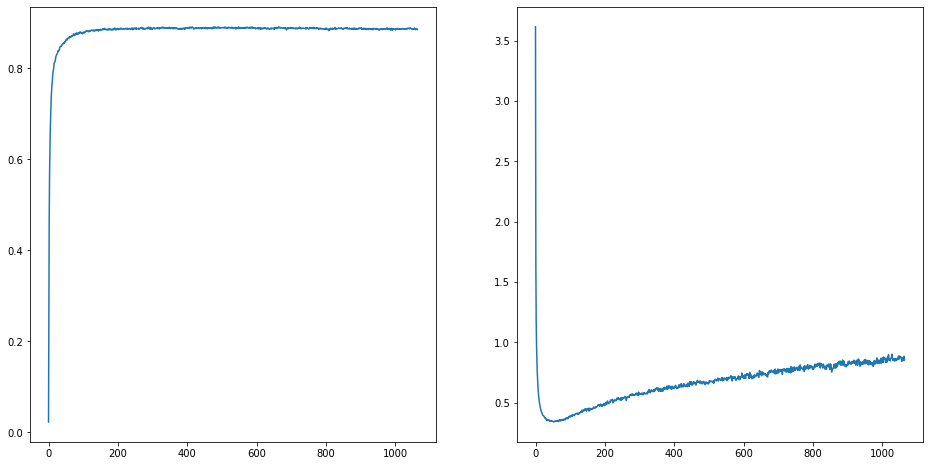

In [17]:
plot_curves(model)